In [ ]:
import os
import re
import csv
import nltk
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from numpy.linalg import norm
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



from google.colab import drive
drive.mount('/content/drive')
random.seed(time.time())
nltk.download('punkt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def cosine_similarity(vector_a, vector_b):
    dot_product = np.dot(vector_a, vector_b)
    norm_a = norm(vector_a)
    norm_b = norm(vector_b)

    similarity = dot_product / (norm_a * norm_b)
    return similarity


def _2file_2data(list_root, list_rand, data):
    row = []
    for file_a in list_file_a:
      with open(file_a, "r") as f:
          normalize_content_a = f.read()

      normalize_content_a = normalize_content_a.replace("\n", " ")

      for file_b in list_file_b:
          with open(file_b, "r") as f:
              normalize_content_b = f.read()

          normalize_content_b = normalize_content_b.replace("\n", " ")
          row.append(normalize_content_a)
          row.append(normalize_content_b)

          if list_root == list_rand:
              row.append(1)
          else:
              row.append(0)
          data.append(row)
          row = []
    return data


In [ ]:
root_folder = '/content/drive/MyDrive/process_data/'

dict_rand_file = {}
data = []

for i in range(1,26):
    list_file_a = []
    list_file_b = []
    folder_path = f'/content/drive/MyDrive/process_data/data/{i}'
    for file_name in os.listdir(folder_path):
        if "NORMALIZE" in file_name:
            file_path = os.path.join(folder_path, file_name)
            list_file_a.append(file_path)

    random_value = random.choice([x for x in range(1, 26) if (x != i and str(i) not in dict_rand_file) or (x != i and str(i) in dict_rand_file and x != dict_rand_file[str(i)])])

    folder_path = f'/content/drive/MyDrive/process_data/data/{random_value}'
    for file_name in os.listdir(folder_path):
        if "NORMALIZE" in file_name:
            file_path = os.path.join(folder_path, file_name)
            list_file_b.append(file_path)

    dict_rand_file[str(random_value)] = str(i)

    data = _2file_2data(list_file_a, list_file_b, data)
    data = _2file_2data(list_file_b, list_file_a, data)
    data = _2file_2data(list_file_a, list_file_a, data)



In [ ]:
feature_names = ['funct1', 'funct2', 'label']

csv_file_path = '/content/drive/MyDrive/process_data/dataset.csv'

with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(feature_names)
    writer.writerows(data)

df = pd.read_csv(csv_file_path, index_col=False)
df = df.sample(frac=1, random_state=42)
df.head()


,funct1,funct2,label
596,endbr64 push typeone lea typeone typethree lea...,endbr64 push typeone mov typeone typeone sub t...,0
3370,push typeone push typeone sub typeone typefive...,push typeone mov typeone typeone sub typeone t...,0
3048,sub typeone typefive lea typeone typethree xor...,endbr64 push typeone mov typeone typeone sub t...,1
2908,sub typeone typefive lea typeone typethree xor...,endbr64 push typeone push typeone sub typeone ...,0
8,endbr64 push typeone lea typeone typethree lea...,endbr64 push typeone mov typeone typeone sub t...,0


In [ ]:
df.shape

(4800, 3)

In [ ]:
combined_texts = [f"{text_feature1} {text_feature2}" for text_feature1, text_feature2 in zip(df.funct1, df.funct2)]


tokenizer = Tokenizer()
tokenizer.fit_on_texts(combined_texts)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
print(f"Word index length: {len(tokenizer.word_index)}")
print(f"Some words: {list(tokenizer.word_index.keys())[0:200]}")


Word index length: 71
Some words: ['typeone', 'mov', 'typethree', 'call', 'typesix', 'typefive', 'lea', 'typeeight', 'typeseven', 'xor', 'add', 'push', 'pop', 'ret', 'sub', 'jmp', 'typefour', 'je', 'cmp', 'nop', 'test', 'typetwo', 'jne', 'endbr64', 'movsx', 'cs', 'movaps', 'paddd', 'movsxd', 'jbe', 'movd', 'punpcklwd', 'leave', 'movzx', 'punpcklbw', 'xchg', 'pxor', 'psrad', 'and', 'movups', 'ja', 'movdqa', 'shr', 'sar', 'cdqe', 'xorps', 'shl', 'jae', 'notrack', 'pshufd', 'or', 'imul', 'jb', 'setne', 'cmove', 'pcmpgtw', 'punpckhwd', 'psrldq', 'cdq', 'cmovns', 'neg', 'sete', 'cmovne', 'movdqu', 'pcmpgtb', 'punpckhbw', 'data16', 'cqo', 'idiv', 'jge', 'jle']


In [ ]:
max_length = -1

for tweet in df["funct1"]:
    length = len(tweet.split())
    if length > max_length:
        max_length = length

print(f"Maximum token length: {max_length}")

Maximum token length: 360


In [ ]:
sequences_feature1 = tokenizer.texts_to_sequences(df.funct1)
sequences_feature2 = tokenizer.texts_to_sequences(df.funct2)

padded_feature1 = pad_sequences(sequences_feature1, maxlen=max_length, padding='post')
padded_feature2 = pad_sequences(sequences_feature2, maxlen=max_length, padding='post')

input_feature1 = padded_feature1
input_feature2 = padded_feature2



In [ ]:
y = df.label.values
X_train_feature1, X_val_feature1, X_train_feature2, X_val_feature2, y_train, y_val = train_test_split(
    input_feature1, input_feature2, y, test_size=0.3, random_state=42
)


In [ ]:
X_train_feature1.shape

(3360, 360)

In [ ]:
list_word = list(tokenizer.word_index.keys())


In [ ]:
root_folder = '/content/drive/MyDrive/process_data/data/'

content = ""
for i in range(1,26):
  folder_path = f'/content/drive/MyDrive/process_data/data/{str(i)}'
  for file_name in os.listdir(folder_path):
    if "NORMALIZE" in file_name:
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, "r") as f:
            content += f.read() + "\n\n"
tokenized_code = [word_tokenize(line.lower()) for line in content.split('\n') if line]
model = Word2Vec(sentences=tokenized_code, vector_size=300, window=5, min_count=1, workers=4, sg=1)

embedding_dimension = 300
embeddings_matrix = np.zeros((vocab_size, embedding_dimension))
for word, index in tokenizer.word_index.items():
    embeddings_matrix[index] = model.wv[word]


In [ ]:
input_feature1 = tf.keras.layers.Input(shape=(max_length,), name='funct1')
embedding_layer_feature1 = tf.keras.layers.Embedding(
    vocab_size,
    embedding_dimension,
    input_length=max_length,
    weights=[embeddings_matrix],
    trainable=False
)(input_feature1)

input_feature2 = tf.keras.layers.Input(shape=(max_length,), name='funct2')
embedding_layer_feature2 = tf.keras.layers.Embedding(
    vocab_size,
    embedding_dimension,
    input_length=max_length,
    weights=[embeddings_matrix],
    trainable=False
)(input_feature2)

concatenated_features = tf.keras.layers.Concatenate()([embedding_layer_feature1, embedding_layer_feature2])


In [ ]:
cnn_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(units=256, return_sequences=True),
    tf.keras.layers.LSTM(units=128, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="tanh"),
])

main_model = tf.keras.models.Model(inputs=[input_feature1, input_feature2 ], outputs=cnn_lstm_model(concatenated_features))

main_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

main_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 funct1 (InputLayer)         [(None, 360)]                0         []                            
                                                                                                  
 funct2 (InputLayer)         [(None, 360)]                0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 360, 300)             21600     ['funct1[0][0]']              
                                                                                                  
 embedding_5 (Embedding)     (None, 360, 300)             21600     ['funct2[0][0]']              
                                                                                            

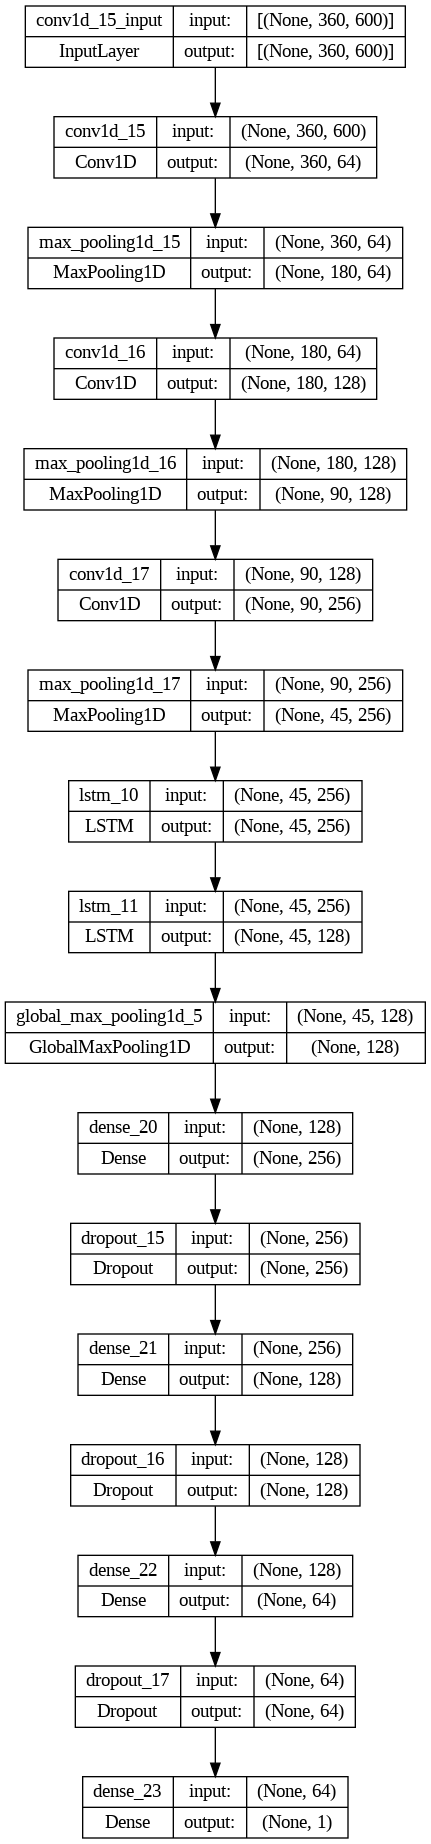

In [102]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# Visualize the CNN+LSTM model
plot_model(cnn_lstm_model, to_file='cnn_lstm_model.png', show_shapes=True, show_layer_names=True)
display(Image(filename='cnn_lstm_model.png'))

In [ ]:
history = main_model.fit(
    [X_train_feature1, X_train_feature2],
    y_train,
    epochs=10,
    batch_size=256,
    validation_data=([X_val_feature1, X_val_feature2], y_val),
)

Epoch 1/10
14/14 [==============================] - 11s 309ms/step - loss: 2.0196 - accuracy: 0.6634 - val_loss: 1.0643 - val_accuracy: 0.6743
Epoch 2/10
14/14 [==============================] - 1s 70ms/step - loss: 1.1198 - accuracy: 0.6634 - val_loss: 0.8012 - val_accuracy: 0.6743
Epoch 3/10
14/14 [==============================] - 1s 69ms/step - loss: 0.8677 - accuracy: 0.6625 - val_loss: 0.6685 - val_accuracy: 0.6743
Epoch 4/10
14/14 [==============================] - 1s 70ms/step - loss: 0.7602 - accuracy: 0.6256 - val_loss: 0.6600 - val_accuracy: 0.6403
Epoch 5/10
14/14 [==============================] - 1s 71ms/step - loss: 0.7337 - accuracy: 0.6110 - val_loss: 0.6532 - val_accuracy: 0.6576
Epoch 6/10
14/14 [==============================] - 1s 72ms/step - loss: 0.7237 - accuracy: 0.6271 - val_loss: 0.6514 - val_accuracy: 0.6736
Epoch 7/10
14/14 [==============================] - 1s 84ms/step - loss: 0.7251 - accuracy: 0.6307 - val_loss: 0.6495 - val_accuracy: 0.6667
Epoch 8/10


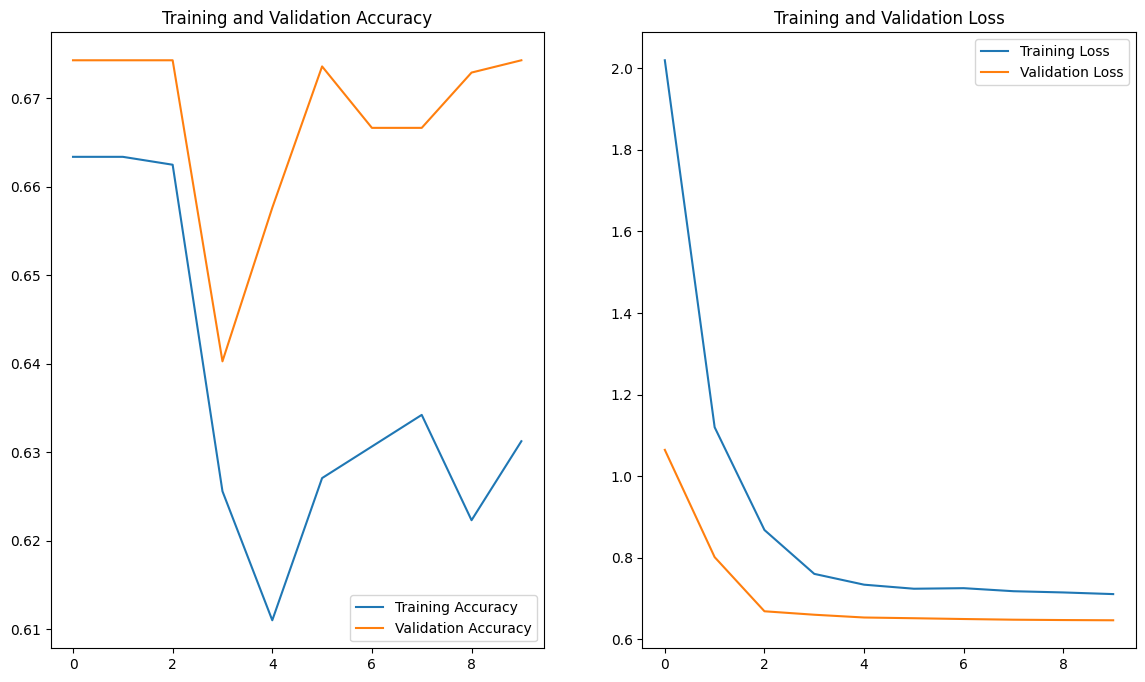

Best accuracy : 0.6743055582046509


In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(len(history.history["loss"]))

plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")

plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")

plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

plt.show()

best_accuracy = max(history.history["val_accuracy"])
print(f"Best accuracy : {best_accuracy}")